In [1]:
import pysmile
import pysmile_license
import numpy as np
import pandas as pd

from df_plot import plot_df 
from info_value_to_net import info_value_to_net
from get_info_values import mutual_info_measures, cond_kl_divergence
from save_info_values import save_info_values

from preprocessing import preprocessing

np.seterr(divide='ignore', invalid = 'ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

### Designing a national strategy

#### Option 1: Perform FIT to the n patients with higher utility measured by the model, being n the number of people that the current screening strategy covers (that is, the number of people above the age of 54)

In [29]:
from preprocessing import preprocessing

flag = True

if not flag:
    df_test = pd.read_csv("private/df_2016.csv")
    df_test = preprocessing(df_test)

    df_test = df_test.rename(columns = {"Hyperchol.": "Hyperchol_"})

    df_utilities_2016 = pd.read_csv("outputs/utilities_2016.csv")

else:
    model_type = "linear"

    net = pysmile.Network()
    net.read_file(f"decision_models/DM_screening_rel_pcmi_{model_type}.xdsl")

    df_test = pd.read_csv("private/df_2016.csv")
    df_test = preprocessing(df_test)

    df_test = df_test.rename(columns = {"Hyperchol.": "Hyperchol_"})

    # Just keep variables that influence the decision
    # df_test.drop(columns = ["Hyperchol_", "Hypertension", "Diabetes", "SES", "Anxiety", "Depression"], inplace = True)

    y = np.array(list(df_test["CRC"]*1))

    vars1 = np.array(["No scr", "gFOBT", "FIT", "Blood_test", "sDNA", "CTC", "CC", "Colonoscopy"])

    df_utilities_2016 = pd.DataFrame([], columns = vars1)

    for i in range(df_test.shape[0]):
        sample = df_test.iloc[i].drop(labels = ["CRC"])
        sample_dict = sample.to_dict() 

        net.clear_all_evidence()

        for key, value in sample.items():
            if type(value) == np.bool_:
                net.set_evidence(key, bool(value))
            else:
                net.set_evidence(key, value)

        net.update_beliefs()

        arr = np.array(net.get_node_value("U"))

        U = np.concatenate((arr[::2], [arr[1]]), axis = 0)

        row = pd.DataFrame(U.reshape(1,8), columns=vars1)
        df_utilities_2016 = pd.concat([df_utilities_2016, row], ignore_index = True)

    df_utilities_2016 = pd.concat( [df_utilities_2016, df_test["CRC"] ] , axis = 1)
    df_utilities_2016.to_csv("outputs/utilities_2016_fulldataset.csv", index = False)


C:\Users\danie\AppData\Local\Temp\ipykernel_25940\2674396849.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_utilities_2016 = pd.concat([df_utilities_2016, row], ignore_index = True)


In [37]:
df_utilities_2016[ df_utilities_2016["No scr"] > df_utilities_2016["FIT"]]

,No scr,gFOBT,FIT,Blood_test,sDNA,CTC,CC,Colonoscopy,CRC
43,0.626752,0.550666,0.585500,0.418405,0.413935,0.430863,0.343452,0.407048,False
55,0.626752,0.550666,0.585500,0.418405,0.413935,0.430863,0.343452,0.407048,False
63,0.626752,0.550666,0.585500,0.418405,0.413935,0.430863,0.343452,0.407048,False
125,0.626752,0.562749,0.606728,0.432685,0.437165,0.443948,0.364391,0.451208,False
130,0.626752,0.557213,0.597058,0.426140,0.426558,0.437949,0.354813,0.431225,False
...,...,...,...,...,...,...,...,...,...
339652,0.626752,0.557213,0.597058,0.426140,0.426558,0.437949,0.354813,0.431225,False
339666,0.626752,0.562749,0.606728,0.432685,0.437165,0.443948,0.364391,0.451208,False
339667,0.626752,0.550666,0.585500,0.418405,0.413935,0.430863,0.343452,0.407048,False
339674,0.626752,0.569209,0.617892,0.440328,0.449465,0.450959,0.375537,0.474001,False


In [65]:
df_selected_current_strategy = df_test[df_test["Age"] == "age_5_old_adult"]
tot_num_patients = df_selected_current_strategy.shape[0]   
print("------------------------")
print("Number of selected patients by current strategy is: ", tot_num_patients)
print("Number of patients with CRC by current strategy is: ", df_selected_current_strategy["CRC"].sum())
print("Percentage of total patients with CRC detected:",  (df_selected_current_strategy["CRC"].sum() / df_test["CRC"].sum()).round(4) * 100, "%")

ind = df_utilities_2016.sort_values(by = "FIT", ascending = False)[:tot_num_patients].index.to_list()
df_selected_new_strategy = df_utilities_2016[ df_utilities_2016["No scr"] < df_utilities_2016["FIT"]].loc[ind]
print("------------------------")
print("Selecting the same number of patients for the new strategy, that is, ", df_selected_new_strategy.sort_values(by = "FIT", ascending = False)[:tot_num_patients].shape[0])
print("Number of patentes with CRC by new strategy is: ", df_selected_new_strategy.sort_values(by = "FIT", ascending = False)[:tot_num_patients]["CRC"].sum())
print("Percentage of total patients with CRC detected:", (df_selected_new_strategy.sort_values(by = "FIT", ascending = False)[:tot_num_patients]["CRC"].sum() / df_test["CRC"].sum()).round(4) * 100, "%")

print("------------------------")
print("This is an improvement of ", df_selected_new_strategy.sort_values(by = "FIT", ascending = False)[:tot_num_patients]["CRC"].sum() - df_selected_current_strategy["CRC"].sum(), "patients")
print("A proportional improvement of ", ((df_selected_new_strategy.sort_values(by = "FIT", ascending = False)[:tot_num_patients]["CRC"].sum() - df_selected_current_strategy["CRC"].sum()) / df_selected_current_strategy["CRC"].sum()).round(4) * 100, "%")

------------------------
Number of selected patients by current strategy is:  49074
Number of patients with CRC by current strategy is:  107
Percentage of total patients with CRC detected: 49.08 %
------------------------
Selecting the same number of patients for the new strategy, that is,  49074
Number of patentes with CRC by new strategy is:  109
Percentage of total patients with CRC detected: 50.0 %
------------------------
This is an improvement of  2 patients
A proportional improvement of  1.87 %


**Comment:** Using the full dataset with information on the medical conditions, we improve in detecting CRC as now our target population has 2 more actual CRC positive patients. This is a small improvement (around 2%) but it might mean 2 lives saved. On the contrary, using the selected variables for the decision node (that is, the ones that are simpler and supposedly do not require a GP check) does not change the number of CRC detected patients.

-> **Questions:**
- Does the target population even change at all for the second case?
- What is the effect of adding each of the medical conditions separately?

#### Option 2: Apply new national strategy with N FITs and M colonoscopies available.

In [4]:
N_FIT = 2000
M_COL = 600

In [2]:
import numpy as np
import pandas as pd

def simulate_test_results(sensitivity_scr, specificity_scr,
                           sensitivity_col, specificity_col, y_crc):
    """
    Simulate test results based on sensitivity, specificity, and actual number of patients
    with and without the disease.
    
    Parameters:
    - sensitivity (float): Sensitivity of the test (true positive rate)
    - specificity (float): Specificity of the test (true negative rate)
    - num_with_disease (int): Number of patients who have the disease
    - num_without_disease (int): Number of patients who do not have the disease
    
    Returns:
    - pandas DataFrame: A DataFrame with the simulated test results, true conditions, and test outcomes.
    """
    

    num_with_disease = y_crc.sum()
    num_without_disease = len(y_crc) - num_with_disease

    # Step 1: Create a list of patients with and without the disease
    
    # Step 2: Simulate test results
    scr_results = []
    col_results = []
    
    for y in y_crc:
        if y == 1:
            # Patient has the disease, test is positive with probability = sensitivity
            scr_result = np.random.choice([1, 0], p=[sensitivity_scr, 1 - sensitivity_scr])
        else:
            # Patient does not have the disease, test is negative with probability = specificity
            scr_result = np.random.choice([0, 1], p=[specificity_scr, 1 - specificity_scr])

        scr_results.append(scr_result)
    
    # Step 3: Create a DataFrame to store the results
    df_scr = pd.DataFrame({
        'Condition': y_crc,    # True condition of the patient
        'TestResult': scr_results  # Simulated test result
    })


    # For FIT positives, perform colonoscopy:
    FIT_positives = df_scr[df_scr["TestResult"] == 1]

    conditions = FIT_positives["Condition"].to_list()

    col_results = []

    for condition in conditions:
        if condition == 1:
            # Patient has the disease, test is positive with probability = sensitivity
            col_result = np.random.choice([1, 0], p=[sensitivity_col, 1 - sensitivity_col])
        else:
            # Patient does not have the disease, test is negative with probability = specificity
            col_result = np.random.choice([0, 1], p=[specificity_col, 1 - specificity_col])

        col_results.append(col_result)

    # Step 5: Create a DataFrame to store the results
    df_col = pd.DataFrame({
        'Condition': conditions,    # True condition of the patient
        'TestResult': col_results  # Simulated test result
    })

    
    
    return df_scr, df_col

In [3]:
def output_test_results(df_scr, cost_scr, df_col, cost_col, verbose = False):

    # Add columns to indicate true positives, false positives, etc.
    df_scr['TruePositive'] = (df_scr['Condition'] == 1) & (df_scr['TestResult'] == 1)
    df_scr['FalsePositive'] = (df_scr['Condition'] == 0) & (df_scr['TestResult'] == 1)
    df_scr['TrueNegative'] = (df_scr['Condition'] == 0) & (df_scr['TestResult'] == 0)
    df_scr['FalseNegative'] = (df_scr['Condition'] == 1) & (df_scr['TestResult'] == 0)
    
    # Step 4: Calculate confusion matrix components
    TP_scr = df_scr['TruePositive'].sum()
    FP_scr = df_scr['FalsePositive'].sum()
    TN_scr = df_scr['TrueNegative'].sum()
    FN_scr = df_scr['FalseNegative'].sum()
    
    # Create confusion matrix
    confusion_matrix_scr = pd.DataFrame({
        'Predicted Negative': [TN_scr, FN_scr],
        'Predicted Positive': [FP_scr, TP_scr]
    }, index=['Actual Negative', 'Actual Positive'])


    FIT_positives = df_scr[df_scr["TestResult"] == 1]
    patient_data = df_scr["Condition"]

    if verbose:
        print("Number of patients considered: ", patient_data.shape[0])
        print(f"Cost of screening: {cost_scr*(patient_data.shape[0])} €")
        print("Number of FIT positives: ", FIT_positives.shape[0])
        print("Number of colonoscopies to be done: ", FIT_positives.shape[0])
        print(f"Cost of colonoscopy program: {cost_col*FIT_positives.shape[0]} €")

    
    # Add columns to indicate true positives, false positives, etc.
    df_col['TruePositive'] = (df_col['Condition'] == 1) & (df_col['TestResult'] == 1)
    df_col['FalsePositive'] = (df_col['Condition'] == 0) & (df_col['TestResult'] == 1)
    df_col['TrueNegative'] = (df_col['Condition'] == 0) & (df_col['TestResult'] == 0)
    df_col['FalseNegative'] = (df_col['Condition'] == 1) & (df_col['TestResult'] == 0)

    # Step 6: Calculate confusion matrix components
    TP_col = df_col['TruePositive'].sum()
    FP_col = df_col['FalsePositive'].sum()
    TN_col = df_col['TrueNegative'].sum()
    FN_col = df_col['FalseNegative'].sum()

    # Create confusion matrix
    confusion_matrix_col = pd.DataFrame({
        'Predicted Negative': [TN_col, FN_col],
        'Predicted Positive': [FP_col, TP_col]
    }, index=['Actual Negative', 'Actual Positive'])

    total_cost = cost_scr*df_scr["Condition"].shape[0] + cost_col*FIT_positives.shape[0]

    if verbose:
        print("Number of CRC true positive cases detected by colonoscopy: ", TP_scr)
        print("Number of false positives by colonoscopy: ", FP_scr)
        print(f"Total cost of screening and colonoscopy: {total_cost} €")
        print("Proportion of total CRC cases in the whole population detected by the method: ", TP_scr / df_test["CRC"].sum())
        print("Proportion of cases in the high-risk target population detected by the method: ", TP_scr / y.sum())

    combined_confusion_matrix = pd.DataFrame({
        'Predicted Negative': [TN_scr + TN_col, FN_scr + FN_col],
        'Predicted Positive': [FP_col, TP_col]
    }, index=['Actual Negative', 'Actual Positive'])

    # Calculate sensitivity and specificity using the combined confusion matrix
    sensitivity = TP_col / (TP_col + FN_col + FN_scr)
    specificity = (TN_scr + TN_col) / (TN_scr +TN_col + FP_col)
    PPV = TP_col / (TP_col + FP_col)
    NPV = (TN_scr + TN_col) / (TN_scr + TN_col + FN_scr + FN_col)

    metrics = {
        "sensitivity": sensitivity,
        "specificity": specificity,
        "PPV": PPV,
        "NPV": NPV
    }
    
    return confusion_matrix_scr, confusion_matrix_col, combined_confusion_matrix, total_cost, metrics
    

**Old screening strategy**

In [6]:
df_test = pd.read_csv("private/df_2016.csv")
df_test = preprocessing(df_test)

df_test = df_test.rename(columns = {"Hyperchol.": "Hyperchol_"})

In [7]:
sensitivity_scr = 0.75
specificity_scr = 0.966
cost_scr = 14.34

sensitivity_col = 0.95
specificity_col = 0.99
cost_col = 1000

# Select old adults as high-risk target population
y = np.array(list(df_test[df_test["Age"] == "age_5_old_adult"]["CRC"]*1))

df_scr, df_col = simulate_test_results(sensitivity_scr, specificity_scr, sensitivity_col, specificity_col, y)

In [8]:
confusion_matrix_scr, confusion_matrix_col, combined_confusion_matrix, total_cost, metrics = output_test_results(df_scr, cost_scr, df_col, cost_col, verbose = True)

Number of patients considered:  49074
Cost of screening: 703721.16 €
Number of FIT positives:  1734
Number of colonoscopies to be done:  1734
Cost of colonoscopy program: 1734000 €
Number of CRC true positive cases detected by colonoscopy:  75
Number of false positives by colonoscopy:  1659
Total cost of screening and colonoscopy: 2437721.16 €
Proportion of total CRC cases in the whole population detected by the method:  0.3440366972477064
Proportion of cases in the high-risk target population detected by the method:  0.7009345794392523


In [9]:
confusion_matrix_scr

,Predicted Negative,Predicted Positive
Actual Negative,47308,1659
Actual Positive,32,75


In [10]:
confusion_matrix_col

,Predicted Negative,Predicted Positive
Actual Negative,1646,13
Actual Positive,1,74


In [11]:
combined_confusion_matrix

,Predicted Negative,Predicted Positive
Actual Negative,48954,13
Actual Positive,33,74


In [12]:
metrics

{'sensitivity': 0.6915887850467289,
 'specificity': 0.9997345150815855,
 'PPV': 0.8505747126436781,
 'NPV': 0.9993263518892768}

**New screening strategy**

Say we have 10,000 FITs and 2,000 colonoscopies. We would take the first 2,000 patients with highest utility based on our model and perform FIT on them. If positive, then proceed with a colonoscopy.

In [13]:
df_utilities_2016 = pd.read_csv("utilities_2016.csv")
df_utilities_2016_sorted = df_utilities_2016.sort_values(by = "FIT", ascending = False)

In [14]:
sensitivity_scr = 0.75
specificity_scr = 0.966
cost_scr = 14.34

sensitivity_col = 0.95
specificity_col = 0.99
cost_col = 1000

# Select as high-risk target population the top 20000 patients according to utility in our model
y = np.array(list(df_utilities_2016_sorted["CRC"]*1))[:49074]

df_scr,  df_col = simulate_test_results(sensitivity_scr, specificity_scr, sensitivity_col, specificity_col, y)

In [15]:
confusion_matrix_scr, confusion_matrix_col, combined_confusion_matrix, total_cost, metrics = output_test_results(df_scr, cost_scr, df_col, cost_col, verbose = True)

Number of patients considered:  49074
Cost of screening: 703721.16 €
Number of FIT positives:  1667
Number of colonoscopies to be done:  1667
Cost of colonoscopy program: 1667000 €
Number of CRC true positive cases detected by colonoscopy:  83
Number of false positives by colonoscopy:  1584
Total cost of screening and colonoscopy: 2370721.16 €
Proportion of total CRC cases in the whole population detected by the method:  0.38073394495412843
Proportion of cases in the high-risk target population detected by the method:  0.7614678899082569


In [16]:
confusion_matrix_scr

,Predicted Negative,Predicted Positive
Actual Negative,47381,1584
Actual Positive,26,83


In [17]:
confusion_matrix_col

,Predicted Negative,Predicted Positive
Actual Negative,1573,11
Actual Positive,3,80


In [18]:
combined_confusion_matrix

,Predicted Negative,Predicted Positive
Actual Negative,48954,11
Actual Positive,29,80


In [19]:
metrics

{'sensitivity': 0.7339449541284404,
 'specificity': 0.9997753497396099,
 'PPV': 0.8791208791208791,
 'NPV': 0.999407957862932}

### Simulation

In [21]:
n_samples = 200

sensitivity_scr = 0.75
specificity_scr = 0.966
cost_scr = 14.34

sensitivity_col = 0.95
specificity_col = 0.99
cost_col = 1000

total_cost_old_strat = 0
total_cost_new_strat = 0  

metrics_tot_old = np.array([0.0,0.0,0.0,0.0])
metrics_tot_new = np.array([0.0,0.0,0.0,0.0])

# Old strategy
# Select old adults as high-risk target population
y_old = np.array(list(df_test[df_test["Age"] == "age_5_old_adult"]["CRC"]*1))
patients_selected = y_old.shape[0]

# New strategy
# Select as high-risk target population the top --- patients according to utility in our model
y_new = np.array(list(df_utilities_2016_sorted["CRC"]*1))[:patients_selected]

for i in range(n_samples):

    # -----
    df_scr,  df_col = simulate_test_results(sensitivity_scr, specificity_scr, sensitivity_col, specificity_col, y_old)
    confusion_matrix_scr, confusion_matrix_col, combined_confusion_matrix, total_cost, metrics = output_test_results(df_scr, cost_scr, df_col, cost_col, verbose = False)

    if i == 0:
        metrics_tot_old = np.array([*metrics.values()])
    else:
        metrics_tot_old = np.concatenate((metrics_tot_old, np.array([*metrics.values()])), axis = 0)

    total_cost_old = cost_scr*df_scr.shape[0] + cost_col*df_col.shape[0]
    total_cost_old_strat += total_cost_old


    # -----
    df_scr,  df_col = simulate_test_results(sensitivity_scr, specificity_scr, sensitivity_col, specificity_col, y_new)
    confusion_matrix_scr, confusion_matrix_col, combined_confusion_matrix, total_cost, metrics = output_test_results(df_scr, cost_scr, df_col, cost_col, verbose = False)

    if i == 0:
        metrics_tot_new = np.array([*metrics.values()])
    else:
        metrics_tot_new = np.concatenate((metrics_tot_new, np.array([*metrics.values()])), axis = 0)

    total_cost_new = total_cost = cost_scr*df_scr.shape[0] + cost_col*df_col.shape[0]
    total_cost_new_strat += total_cost_new

    if (i+1) % 20 == 0:
        print(f"Sample {i+1} done")


metrics_tot_old = metrics_tot_old.reshape(n_samples, 4)
metrics_tot_new = metrics_tot_new.reshape(n_samples, 4)

print("Average metrics for old strategy: ", metrics_tot_old.mean(axis=0))
print("Std for estimates: " , metrics_tot_old.std(axis=0))
print("Average cost of old strategy: ", total_cost_old_strat / n_samples)

print("Average metrics for new strategy: ", metrics_tot_new.mean(axis=0), "(+/-" , metrics_tot_new.std(axis=0), ")")
print("Std for estimates: " , metrics_tot_new.std(axis=0))
print("Average cost of new strategy: ", total_cost_new_strat / n_samples)

Sample 20 done
Sample 40 done
Sample 60 done
Sample 80 done
Sample 100 done
Sample 120 done
Sample 140 done
Sample 160 done
Sample 180 done
Sample 200 done
Average metrics for old strategy:  [0.71070093 0.99965834 0.82071877 0.99936803]
Std for estimates:  [4.55582075e-02 8.34731953e-05 3.77652862e-02 9.94610607e-05]
Average cost of old strategy:  2447711.16000001
Average metrics for new strategy:  [0.70779817 0.99965782 0.82264662 0.99934975] (+/- [4.23983260e-02 8.01576064e-05 3.50670101e-02 9.42864195e-05] )
Std for estimates:  [4.23983260e-02 8.01576064e-05 3.50670101e-02 9.42864195e-05]
Average cost of new strategy:  2448911.16000001


In [30]:
metrics_tot_old = np.concatenate((metrics_tot_old, np.array([*metrics.values()])), axis = 0)
metrics_tot_old.reshape(7,4)

array([[357.39252336, 499.82835379, 410.30531622, 499.68847327],
       [  0.65137615,   0.99965281,   0.80681818,   0.99922427],
       [  0.65137615,   0.99965281,   0.80681818,   0.99922427],
       [  0.65137615,   0.99965281,   0.80681818,   0.99922427],
       [  0.65137615,   0.99965281,   0.80681818,   0.99922427],
       [  0.65137615,   0.99965281,   0.80681818,   0.99922427],
       [  0.65137615,   0.99965281,   0.80681818,   0.99922427]])

In [34]:
metrics_tot_old.reshape(7,4).mean(axis = 0)

array([51.61439718, 72.26089581, 59.30660362, 72.24054555])

In [123]:
n_samples = 100

sensitivity_scr = 0.75
specificity_scr = 0.966
cost_scr = 14.34

sensitivity_col = 0.95
specificity_col = 0.99
cost_col = 1000

total_cost_old_strat = 0
total_cost_new_strat = 0  

metrics_tot_old = np.array([0.0,0.0,0.0,0.0])
metrics_tot_new = np.array([0.0,0.0,0.0,0.0])


def run_iteration(i, df_test, df_utilities_2016_sorted, sensitivity_scr, specificity_scr, sensitivity_col, specificity_col, cost_scr, cost_col):

    # Old strategy
    # Select old adults as high-risk target population
    y = np.array(list(df_test[df_test["Age"] == "age_5_old_adult"]["CRC"]*1))
    patients_selected = y.shape[0]

    df_scr,  df_col = simulate_test_results(sensitivity_scr, specificity_scr, sensitivity_col, specificity_col, y)
    confusion_matrix_scr, confusion_matrix_col, combined_confusion_matrix, total_cost, metrics_old = output_test_results(df_scr, cost_scr, df_col, cost_col, verbose = False)

    total_cost_old_value = cost_scr*df_scr.shape[0] + cost_col*df_col.shape[0]


    # New strategy
    # Select as high-risk target population the top --- patients according to utility in our model
    y = np.array(list(df_utilities_2016_sorted["CRC"]*1))[:patients_selected]

    df_scr,  df_col = simulate_test_results(sensitivity_scr, specificity_scr, sensitivity_col, specificity_col, y)
    confusion_matrix_scr, confusion_matrix_col, combined_confusion_matrix, total_cost, metrics_new = output_test_results(df_scr, cost_scr, df_col, cost_col, verbose = False)

    metrics_tot_new += np.array([*metrics.values()])

    total_cost_new_value = total_cost = cost_scr*df_scr.shape[0] + cost_col*df_col.shape[0]


    return {
        "metrics_old": metrics_old,
        "total_cost_old": total_cost_old_value,
        "metrics_new": metrics_new,
        "total_cost_new": total_cost_new_value
    }



In [124]:
import numpy as np
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed

# Parameters
n_samples = 100  # Define your number of samples here
metrics_tot_old = np.zeros(4)  # Adjust based on your metrics' size
metrics_tot_new = np.zeros(4)  # Adjust based on your metrics' size
total_cost_old_strat = 0
total_cost_new_strat = 0

# Create a process pool
with ProcessPoolExecutor() as executor:
    # Submit all iterations
    futures = {executor.submit(run_iteration, i, df_test, df_utilities_2016_sorted, sensitivity_scr, specificity_scr, sensitivity_col, specificity_col, cost_scr, cost_col): i for i in range(n_samples)}

    for future in as_completed(futures):
        result = future.result()
        metrics_tot_old += np.array([*result["metrics_old"].values()])
        total_cost_old_strat += result["total_cost_old"]
        
        metrics_tot_new += np.array([*result["metrics_new"].values()])
        total_cost_new_strat += result["total_cost_new"]
        
        sample_index = futures[future]
        if (sample_index + 1) % 20 == 0:
            print(f"Sample {sample_index} done")

# Final results
print("Average metrics for old strategy: ", metrics_tot_old / n_samples)
print("Average cost of old strategy: ", total_cost_old_strat / n_samples)

print("Average metrics for new strategy: ", metrics_tot_new / n_samples)
print("Average cost of new strategy: ", total_cost_new_strat / n_samples)

# USE CASE: DESIGN A NATIONAL STRATEGY DIRECTLY FROM THE NETWORK

The network will give out the utility of each method for each segment of patients in the population. Taking the maximum utility for each segment will lead us to choosing or not a screening method. Once it is chosen, we simulate the result of screening and that of colonoscopy, following the criteria of performing a mandatory colonoscopy when the result of screening is positive. A colonoscopy is also contemplated when no screening is done. After the assignment of the methods, a budget is calculated considering certain material restrictions such as limited amounts of tests.

In [2]:
net = pysmile.Network()
net.read_file(f"outputs/linear_rel_point_cond_mut_info_elicitFalse_newtestFalse/decision_models/DM_screening_rel_point_cond_mut_info_linear.xdsl")


In [3]:
net.get_parent_ids("Screening")

['PA', 'SD', 'Smoking', 'BMI', 'Alcohol', 'Sex', 'Age']

In [4]:
import itertools

parents = net.get_parent_ids("Screening")
parent_states = [net.get_outcome_ids(parent) for parent in parents]
parent_combinations = list(itertools.product(*parent_states))

possible_outcomes = net.get_outcome_ids("Screening")
possible_outcomes.insert(0, "No_scr_no_col")
possible_outcomes[1] = "No_scr_col"

counts = np.zeros(len(possible_outcomes))
all_values = []
best_options = []   

net.clear_all_evidence()
for elem in parent_combinations:

    for i in range(len(parents)):
        net.set_evidence(parents[i], elem[i])
    net.update_beliefs()

    values = net.get_node_value("Screening") 
    values.insert(1, net.get_node_value("Colonoscopy")[1])

    max_index = values.index(max(values))
    best_options.append(possible_outcomes[max_index])

    counts[max_index] += 1

    all_values.append(values)



Text(0.5, 0, 'Screening outcome')

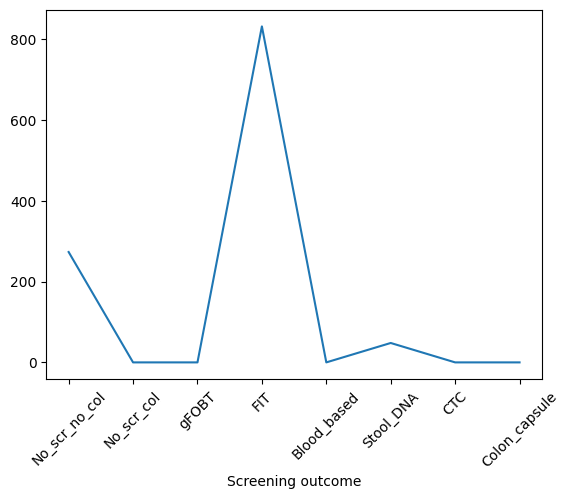

In [5]:
from matplotlib import pyplot as plt

plt.plot(counts)
plt.xticks(range(len(possible_outcomes)), possible_outcomes, rotation = 45)
plt.xlabel("Screening outcome")

In [36]:
from preprocessing import preprocessing

flag = True

if not flag:
    df_test = pd.read_csv("private/df_2016.csv")
    df_test = preprocessing(df_test)

    df_test = df_test.rename(columns = {"Hyperchol.": "Hyperchol_"})

    df_utilities_2016 = pd.read_csv("outputs/utilities_2016_fulldataset.csv")

    possible_outcomes = net.get_outcome_ids("Screening")
    possible_outcomes.insert(0, "No_scr_no_col")
    possible_outcomes[1] = "No_scr_col"

    counts = np.zeros(len(possible_outcomes))
    all_values = []
    best_options = []

    for i in range(df_utilities_2016.shape[0]):
        max_index = np.argmax(df_utilities_2016.iloc[i].values[:-1])
        best_options.append(possible_outcomes[max_index])

        counts[max_index] += 1

    best_options_df = pd.DataFrame(best_options, columns = ["Best_option"])



else:
    model_type = "linear"

    net = pysmile.Network()
    net.read_file(f"outputs/linear_rel_point_cond_mut_info_elicitFalse_newtestFalse/decision_models/DM_screening_rel_point_cond_mut_info_linear.xdsl")

    df_test = pd.read_csv("private/df_2016.csv")
    df_test = preprocessing(df_test)

    df_test = df_test.rename(columns = {"Hyperchol.": "Hyperchol_"})

    # Just keep variables that influence the decision
    df_test.drop(columns = ["Hyperchol_", "Hypertension", "Diabetes", "SES", "Anxiety", "Depression"], inplace = True)

    # df_test = df_test.sample(20000, random_state = 42).reset_index(drop=True)

    y = np.array(list(df_test["CRC"]*1))

    possible_outcomes = net.get_outcome_ids("Screening")
    possible_outcomes.insert(0, "No_scr_no_col")
    possible_outcomes[1] = "No_scr_col"

    counts = np.zeros(len(possible_outcomes))
    all_values = []
    best_options = []

    df_utilities_2016 = pd.DataFrame([], columns = possible_outcomes)

    # 1. Identify unique rows
    unique_rows = df_test.drop(columns="CRC").copy()
    unique_rows = unique_rows.drop_duplicates().copy()

    # 2. Define a function to calculate the utility for a given row
    def calculate_utility(row):
        sample = row.to_dict()
        net.clear_all_evidence()

        for key, value in sample.items():
            if type(value) == np.bool_:
                net.set_evidence(key, bool(value))
            else:
                net.set_evidence(key, value)

        net.update_beliefs()

        utilities = net.get_node_value("Screening") 
        utilities.insert(1, net.get_node_value("Colonoscopy")[1])

        return np.array(utilities)

    def argmax_utility(row):
        x = row["utilities"]
        return possible_outcomes[np.argmax(x)]
    

    # 3. Apply the function to the unique rows and store the result in a new column
    unique_rows['utilities'] = unique_rows.apply(calculate_utility, axis = 1)
    unique_rows['best_option'] = unique_rows.apply(argmax_utility, axis = 1)

    # 4. Map these calculated values back to the original DataFrame
    # Using a merge or map-like operation to match the calculated values to duplicates
    df_with_calculated = df_test.merge(unique_rows, on=list(df_test.drop(columns="CRC").columns), how='left')

    utilities_series = pd.Series(df_with_calculated['utilities'].values)

    # 1. Convert each element (list of lists) into a 2D numpy array
    utilities_2d_list = [np.array(sublist) for sublist in utilities_series]

    # 2. Flatten into a DataFrame with a MultiIndex for rows and columns
    # Assuming each sublist has a shape (m, n), we can concatenate them along axis=0
    df_utilities_2016 = pd.DataFrame(np.vstack(utilities_2d_list), columns = possible_outcomes)
    df_utilities_2016["best_option"] = df_with_calculated["best_option"]

    # best_options = df_utilities_2016.apply(lambda x: possible_outcomes[np.argmax(x)], axis=1)
    counts = df_utilities_2016["best_option"].value_counts()
    counts = counts.reindex(possible_outcomes, fill_value=0)

    # best_options_df = pd.DataFrame(best_options, columns = ["Best_option"])

    df_test = df_test.merge(df_utilities_2016, left_index=True, right_index=True)

    # df_utilities_2016 = pd.concat( [df_utilities_2016, df_test["CRC"] ] , axis = 1)
    # df_utilities_2016.to_csv("outputs/utilities_2016_fulldataset.csv", index = False)


Text(0.5, 0, 'Screening outcome')

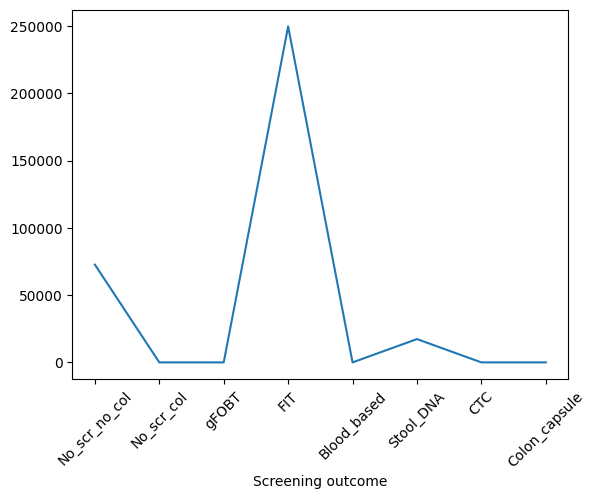

In [8]:
plt.plot(counts)
plt.xticks(range(len(possible_outcomes)), possible_outcomes, rotation = 45)
plt.xlabel("Screening outcome")

In [61]:
selected_patients = df_test.loc[df_test[df_test["best_option"] == possible_outcomes[3]].index].copy()

y_selected_patients = selected_patients["CRC"]

df_test.loc[selected_patients.index, "Prediction_screening"] = 0
df_test.loc[selected_patients.index, "Prediction_colonoscopy"] = 0
df_test.loc[selected_patients.index, "Final_decision"] = 0

df_test

,Age,Sex,BMI,Alcohol,Smoking,PA,SD,CRC,No_scr_no_col,No_scr_col,...,FIT,Blood_based,Stool_DNA,CTC,Colon_capsule,best_option,Prediction_screening,Prediction_colonoscopy,Final_decision,Colonoscopy
0,age_3_young_adult,M,bmi_3_overweight,low,sm_1_not_smoker,PA_2,SD_2_normal,False,0.11963,0.085862,...,0.120077,0.097087,0.111809,0.107616,0.090334,FIT,0.0,0.0,0.0,NaN
1,age_4_adult,M,bmi_3_overweight,low,sm_2_smoker,PA_1,SD_2_normal,False,0.11963,0.091075,...,0.121537,0.099706,0.116201,0.110701,0.093073,FIT,0.0,0.0,0.0,NaN
2,age_5_old_adult,M,bmi_4_obese,low,sm_3_ex_smoker,PA_2,SD_2_normal,False,0.11963,0.104507,...,0.125568,0.105332,0.126059,0.117263,0.099066,Stool_DNA,NaN,NaN,NaN,NaN
3,age_4_adult,M,bmi_2_normal,low,sm_1_not_smoker,PA_2,SD_2_normal,False,0.11963,0.094078,...,0.122409,0.101262,0.118791,0.112535,0.094718,FIT,0.0,0.0,0.0,NaN
4,age_3_young_adult,M,bmi_3_overweight,low,sm_1_not_smoker,PA_1,SD_2_normal,False,0.11963,0.085811,...,0.120062,0.097058,0.111762,0.107582,0.090304,FIT,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339702,age_4_adult,M,bmi_3_overweight,low,sm_1_not_smoker,PA_1,SD_2_normal,False,0.11963,0.093895,...,0.122367,0.101153,0.118616,0.112406,0.094609,FIT,0.0,0.0,0.0,NaN
339703,age_4_adult,M,bmi_2_normal,low,sm_1_not_smoker,PA_2,SD_2_normal,False,0.11963,0.094078,...,0.122409,0.101262,0.118791,0.112535,0.094718,FIT,0.0,0.0,0.0,NaN
339704,age_4_adult,M,bmi_2_normal,high,sm_1_not_smoker,PA_2,SD_2_normal,False,0.11963,0.094394,...,0.122492,0.101360,0.118978,0.112648,0.094816,FIT,0.0,0.0,0.0,NaN
339705,age_2_young,M,bmi_3_overweight,low,sm_1_not_smoker,PA_2,SD_2_normal,False,0.11963,0.083362,...,0.119304,0.095660,0.109478,0.105928,0.088796,No_scr_no_col,NaN,NaN,NaN,NaN


In [60]:
selected_patients

,Age,Sex,BMI,Alcohol,Smoking,PA,SD,CRC,No_scr_no_col,No_scr_col,...,FIT,Blood_based,Stool_DNA,CTC,Colon_capsule,best_option,Prediction_screening,Prediction_colonoscopy,Final_decision,Colonoscopy


In [54]:
df_test["best_option"] == possible_outcomes[3]

0          True
1          True
2         False
3          True
4          True
          ...  
339702     True
339703     True
339704     True
339705    False
339706     True
Name: best_option, Length: 339707, dtype: bool

In [65]:
selected_patients = df_test.loc[df_test["best_option"] == possible_outcomes[i]].copy()
selected_patients

,Age,Sex,BMI,Alcohol,Smoking,PA,SD,CRC,No_scr_no_col,No_scr_col,...,FIT,Blood_based,Stool_DNA,CTC,Colon_capsule,best_option,Prediction_screening,Prediction_colonoscopy,Final_decision,Colonoscopy


In [66]:
from simulations import simulate_test_results
import time

t1 = time.time()

for i, strategy in enumerate(possible_outcomes):
    
    if strategy == "No_scr_no_col":
        selected_patients = df_test.loc[df_test[df_test["best_option"] == possible_outcomes[i]].index].copy()

        y_selected_patients = selected_patients["CRC"]

        df_test.loc[selected_patients.index, "Prediction_screening"] = 0
        df_test.loc[selected_patients.index, "Prediction_colonoscopy"] = 0
        df_test.loc[selected_patients.index, "Final_decision"] = 0
        continue

    elif strategy == "No_scr_col":
        selected_patients = df_test.loc[df_test[df_test["best_option"] == possible_outcomes[i]].index].copy()

        y_selected_patients = selected_patients["CRC"]

        df_test.loc[selected_patients.index, "Prediction_screening"] = 0

        spec_col = np.array(net.get_node_definition("Results_of_Colonoscopy")).reshape(2,2,3)[0, 1 ,1]
        sens_col = np.array(net.get_node_definition("Results_of_Colonoscopy")).reshape(2,2,3)[1, 1 ,2]

        df_col = simulate_test_results(sens_col, spec_col, y_selected_patients)

        df_test.loc[selected_patients.index, "Prediction_colonoscopy"] = df_col["TestResult"]
        df_test.loc[selected_patients.index, "Final_decision"] = df_col["TestResult"]
        continue

    else:

        selected_patients = df_test.loc[df_test[df_test["best_option"] == possible_outcomes[i]].index].copy()

        y_selected_patients = selected_patients["CRC"]

        spec_strategy = np.array(net.get_node_definition("Results_of_Screening")).reshape(2,7,3)[0, i-1, 1]
        sens_strategy = np.array(net.get_node_definition("Results_of_Screening")).reshape(2,7,3)[1, i-1, 2]

        df_scr = simulate_test_results(sens_strategy, spec_strategy, y_selected_patients) 

        df_test.loc[selected_patients.index, "Prediction_screening"] = df_scr["TestResult"]
        df_test.loc[selected_patients.index, "Prediction_colonoscopy"] = 0
        df_test.loc[selected_patients.index, "Final_decision"] = df_scr["TestResult"]

        # For FIT positives, perform colonoscopy:
        FIT_positives = df_scr[df_scr["TestResult"] == 1]
        y_FIT_positives = FIT_positives["Condition"]

        spec_col = np.array(net.get_node_definition("Results_of_Colonoscopy")).reshape(2,2,3)[0, 1 ,1]
        sens_col = np.array(net.get_node_definition("Results_of_Colonoscopy")).reshape(2,2,3)[1, 1 ,2]
        
        df_col = simulate_test_results(sens_col, spec_col, y_FIT_positives)

        df_test.loc[FIT_positives.index, "Colonoscopy"] = "Colonoscopy"
        df_test.loc[FIT_positives.index, "Prediction_colonoscopy"] = df_col["TestResult"]
        df_test.loc[FIT_positives.index, "Final_decision"] = df_col["TestResult"]


total_cost_of_screening = 0.0
total_cost_of_colonoscopy = 0.0
scr_costs = net.get_node_value("COST")[::2]
scr_costs.insert(1, 0.0)

col_costs = net.get_node_value("COST")[1]

total_cost_of_screening = np.matmul(np.array(scr_costs),counts.values)
total_cost_of_colonoscopy = col_costs*(df_test["Colonoscopy"].value_counts()["Colonoscopy"])


t2 = time.time()

print(f"Total cost of the strategy: {total_cost_of_screening + total_cost_of_colonoscopy:.2f} €")
print(f"Total time for the simulation: {t2 - t1:.2f} seconds")


Total cost of the strategy: 18571210.38 €
Total time for the simulation: 4.96 seconds


In [67]:
df_test["Colonoscopy"].value_counts()["Colonoscopy"]

10821

In [50]:
df_test

,Age,Sex,BMI,Alcohol,Smoking,PA,SD,CRC,No_scr_no_col,No_scr_col,...,FIT,Blood_based,Stool_DNA,CTC,Colon_capsule,best_option,Prediction_screening,Prediction_colonoscopy,Final_decision,Colonoscopy
0,age_3_young_adult,M,bmi_3_overweight,low,sm_1_not_smoker,PA_2,SD_2_normal,False,0.11963,0.085862,...,0.120077,0.097087,0.111809,0.107616,0.090334,FIT,NaN,NaN,NaN,NaN
1,age_4_adult,M,bmi_3_overweight,low,sm_2_smoker,PA_1,SD_2_normal,False,0.11963,0.091075,...,0.121537,0.099706,0.116201,0.110701,0.093073,FIT,NaN,NaN,NaN,NaN
2,age_5_old_adult,M,bmi_4_obese,low,sm_3_ex_smoker,PA_2,SD_2_normal,False,0.11963,0.104507,...,0.125568,0.105332,0.126059,0.117263,0.099066,Stool_DNA,NaN,NaN,NaN,NaN
3,age_4_adult,M,bmi_2_normal,low,sm_1_not_smoker,PA_2,SD_2_normal,False,0.11963,0.094078,...,0.122409,0.101262,0.118791,0.112535,0.094718,FIT,NaN,NaN,NaN,NaN
4,age_3_young_adult,M,bmi_3_overweight,low,sm_1_not_smoker,PA_1,SD_2_normal,False,0.11963,0.085811,...,0.120062,0.097058,0.111762,0.107582,0.090304,FIT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339702,age_4_adult,M,bmi_3_overweight,low,sm_1_not_smoker,PA_1,SD_2_normal,False,0.11963,0.093895,...,0.122367,0.101153,0.118616,0.112406,0.094609,FIT,NaN,NaN,NaN,NaN
339703,age_4_adult,M,bmi_2_normal,low,sm_1_not_smoker,PA_2,SD_2_normal,False,0.11963,0.094078,...,0.122409,0.101262,0.118791,0.112535,0.094718,FIT,NaN,NaN,NaN,NaN
339704,age_4_adult,M,bmi_2_normal,high,sm_1_not_smoker,PA_2,SD_2_normal,False,0.11963,0.094394,...,0.122492,0.101360,0.118978,0.112648,0.094816,FIT,NaN,NaN,NaN,NaN
339705,age_2_young,M,bmi_3_overweight,low,sm_1_not_smoker,PA_2,SD_2_normal,False,0.11963,0.083362,...,0.119304,0.095660,0.109478,0.105928,0.088796,No_scr_no_col,NaN,NaN,NaN,NaN


In [47]:
df_test["Colonoscopy"].value_counts()

KeyError: 'Colonoscopy'

In [45]:
col_costs

1006.2031880000001

In [38]:
scr_costs.insert(1, 0.0)
scr_costs

[0.0, 0.0, 12.14, 14.34, 125.13, 236.88000000000002, 96.534, 510.6123]

In [40]:
counts.values

array([ 72651,      0,      0, 249740,      0,  17316,      0,      0],
      dtype=int64)

In [44]:
np.matmul(np.array(scr_costs),counts.values)

7683085.680000001

In [30]:
df_test

,Age,Sex,BMI,Alcohol,Smoking,PA,SD,CRC,Screening_strategy,Colonoscopy,Prediction_screening,Prediction_colonoscopy,Final_decision
0,age_3_young_adult,M,bmi_3_overweight,low,sm_1_not_smoker,PA_2,SD_2_normal,False,FIT,None,NaN,NaN,NaN
1,age_4_adult,M,bmi_3_overweight,low,sm_2_smoker,PA_1,SD_2_normal,False,FIT,None,NaN,NaN,NaN
2,age_5_old_adult,M,bmi_4_obese,low,sm_3_ex_smoker,PA_2,SD_2_normal,False,Stool_DNA,None,NaN,NaN,NaN
3,age_4_adult,M,bmi_2_normal,low,sm_1_not_smoker,PA_2,SD_2_normal,False,FIT,None,NaN,NaN,NaN
4,age_3_young_adult,M,bmi_3_overweight,low,sm_1_not_smoker,PA_1,SD_2_normal,False,FIT,None,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
339702,age_4_adult,M,bmi_3_overweight,low,sm_1_not_smoker,PA_1,SD_2_normal,False,FIT,None,NaN,NaN,NaN
339703,age_4_adult,M,bmi_2_normal,low,sm_1_not_smoker,PA_2,SD_2_normal,False,FIT,None,NaN,NaN,NaN
339704,age_4_adult,M,bmi_2_normal,high,sm_1_not_smoker,PA_2,SD_2_normal,False,FIT,None,NaN,NaN,NaN
339705,age_2_young,M,bmi_3_overweight,low,sm_1_not_smoker,PA_2,SD_2_normal,False,No_scr_no_col,None,NaN,NaN,NaN


In [24]:
counts = df_utilities_2016["best_option"].value_counts()
counts = counts.reindex(possible_outcomes, fill_value=0)
counts

best_option
No_scr_no_col     72651
No_scr_col            0
gFOBT                 0
FIT              249740
Blood_based           0
Stool_DNA         17316
CTC                   0
Colon_capsule         0
Name: count, dtype: int64

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Example true labels and predictions (replace with your own)
y_true = df_test["CRC"]
y_pred = df_test["Final_decision"]

def plot_classification_results(y_true, y_pred):

    # Create a classification report
    report = classification_report(y_true, y_pred, output_dict=True)

    # Convert the classification report into a DataFrame for easier visualization
    report_df = pd.DataFrame(report).transpose()

    # Generate a confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Calculate sensitivity (recall) and specificity manually
    tn, fp, fn, tp = conf_matrix.ravel()

    # Sensitivity (Recall) is already included in classification report
    sensitivity = report['True']['recall']  # For class 1 (positive class)

    # Specificity calculation
    specificity = tn / (tn + fp)

    # Add Sensitivity and Specificity to the DataFrame
    report_df.loc['sensitivity'] = [sensitivity, np.nan, np.nan, np.nan]
    report_df.loc['specificity'] = [specificity, np.nan, np.nan, np.nan]

    # Plot the confusion matrix using Seaborn for a heatmap
    plt.figure(figsize=(12, 5))

    # First subplot: Confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Second subplot: Classification report as a heatmap
    plt.subplot(1, 2, 2)
    sns.heatmap(report_df.iloc[:, :-1], annot=True, cmap='Blues', cbar=False, fmt='.2f')
    plt.title('Classification Metrics')
    plt.ylabel('Metrics')
    plt.xlabel('Classes')

    plt.tight_layout()
    plt.show()

    return report_df



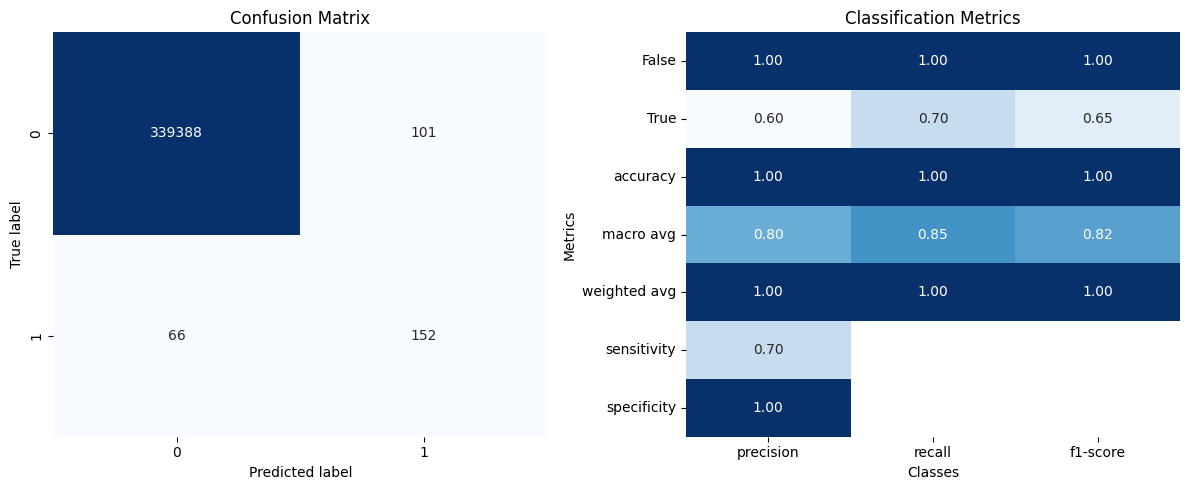

In [14]:
report_df = plot_classification_results(y_true, y_pred)

In [21]:
report_df

,precision,recall,f1-score,support
False,0.999806,0.999702,0.999754,339489.000000
True,0.600791,0.697248,0.645435,218.000000
accuracy,0.999508,0.999508,0.999508,0.999508
macro avg,0.800298,0.848475,0.822595,339707.000000
weighted avg,0.999550,0.999508,0.999527,339707.000000
sensitivity,0.697248,NaN,NaN,NaN
specificity,0.999702,NaN,NaN,NaN


In [111]:
df_test_new_strategy = df_test.copy()

In [25]:
# List of dataframes
dfs = [report_df, report_df, report_df]

# Concatenate along the third axis
concat_df = pd.concat(dfs, axis=0, keys=range(len(dfs)))

# Compute mean and std across the 'keys' axis (axis=0)
mean_df = concat_df.groupby(level=1, sort = False).mean()
std_df = concat_df.groupby(level=1, sort = False).std()

In [26]:
mean_df

,precision,recall,f1-score,support
False,0.999806,0.999702,0.999754,339489.000000
True,0.600791,0.697248,0.645435,218.000000
accuracy,0.999508,0.999508,0.999508,0.999508
macro avg,0.800298,0.848475,0.822595,339707.000000
weighted avg,0.999550,0.999508,0.999527,339707.000000
sensitivity,0.697248,NaN,NaN,NaN
specificity,0.999702,NaN,NaN,NaN


In [27]:
std_df

,precision,recall,f1-score,support
False,0.0,0.0,0.0,0.0
True,0.0,0.0,0.0,0.0
accuracy,0.0,0.0,0.0,0.0
macro avg,0.0,0.0,0.0,0.0
weighted avg,0.0,0.0,0.0,0.0
sensitivity,0.0,NaN,NaN,NaN
specificity,0.0,NaN,NaN,NaN


##### Old strategy

In [108]:
df_test = pd.read_csv("private/df_2016.csv")
df_test = preprocessing(df_test)

df_test = df_test.rename(columns = {"Hyperchol.": "Hyperchol_"})

# Just keep variables that influence the decision
df_test.drop(columns = ["Hyperchol_", "Hypertension", "Diabetes", "SES", "Anxiety", "Depression"], inplace = True)

In [109]:
from simulations import simulate_test_results, output_test_results

df_test["Screening_strategy"] = "FIT"
df_test["Colonoscopy"] = None

selected_patients = df_test[df_test["Age"] == "age_5_old_adult"].copy()
y_selected_patients = selected_patients["CRC"]

# Do FIT to all patients over 50
spec_strategy = np.array(net.get_node_definition("Results_of_Screening")).reshape(2,7,3)[0, 2, 1]
sens_strategy = np.array(net.get_node_definition("Results_of_Screening")).reshape(2,7,3)[1, 2, 2]

df_scr = simulate_test_results(sens_strategy, spec_strategy, y_selected_patients) 

df_test.loc[selected_patients.index, "Prediction_screening"] = df_scr["TestResult"]
df_test.loc[selected_patients.index, "Prediction_colonoscopy"] = 0
df_test.loc[selected_patients.index, "Final_decision"] = df_scr["TestResult"]

# For FIT positives, perform colonoscopy:
FIT_positives = df_scr[df_scr["TestResult"] == 1]
y_FIT_positives = FIT_positives["Condition"]

spec_col = np.array(net.get_node_definition("Results_of_Colonoscopy")).reshape(2,2,3)[0, 1 ,1]
sens_col = np.array(net.get_node_definition("Results_of_Colonoscopy")).reshape(2,2,3)[1, 1 ,2]

df_col = simulate_test_results(sens_col, spec_col, y_FIT_positives)

df_test.loc[FIT_positives.index, "Colonoscopy"] = "Colonoscopy"
df_test.loc[FIT_positives.index, "Prediction_colonoscopy"] = df_col["TestResult"]
df_test.loc[FIT_positives.index, "Final_decision"] = df_col["TestResult"]


total_cost_of_screening = 0.0
total_cost_of_colonoscopy = 0.0
scr_costs = net.get_node_value("COST")[::2]
col_costs = net.get_node_value("COST")[1]

for i in range(df_test.shape[0]):
    scr_strat = df_test.iloc[i]["Screening_strategy"]
    total_cost_of_screening += scr_costs[possible_outcomes.index(scr_strat)]

    if df_test.iloc[i]["Colonoscopy"] == "Colonoscopy":
        total_cost_of_colonoscopy += col_costs

print(f"Total cost of the strategy: {total_cost_of_screening + total_cost_of_colonoscopy:.2f} €")


Total cost of the strategy: 44299584.79 €


In [110]:
df_test_old_strategy = df_test.copy()

In [19]:
report_df

NameError: name 'report_df' is not defined